In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [31]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='Unnamed: 0')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154 entries, 2011-11-30 to 2024-08-31
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              150 non-null    float64
 1   crude_oil_brent_usd_per_bbl              154 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         154 non-null    float64
 3   inflación_mensual                        154 non-null    float64
 4   ipc_diesel                               140 non-null    float64
 5   precipitación_media_mm                   146 non-null    float64
 6   temp_media_Celsius                       146 non-null    float64
 7   fob_otros_prod_agrícolas_exportados_usd  140 non-null    float64
 8   fosfato diamónico 18-46-0                140 non-null    float64
 9   muriato de potasio 0-0-60                140 non-null    float64
 10  urea 46-0-0                    

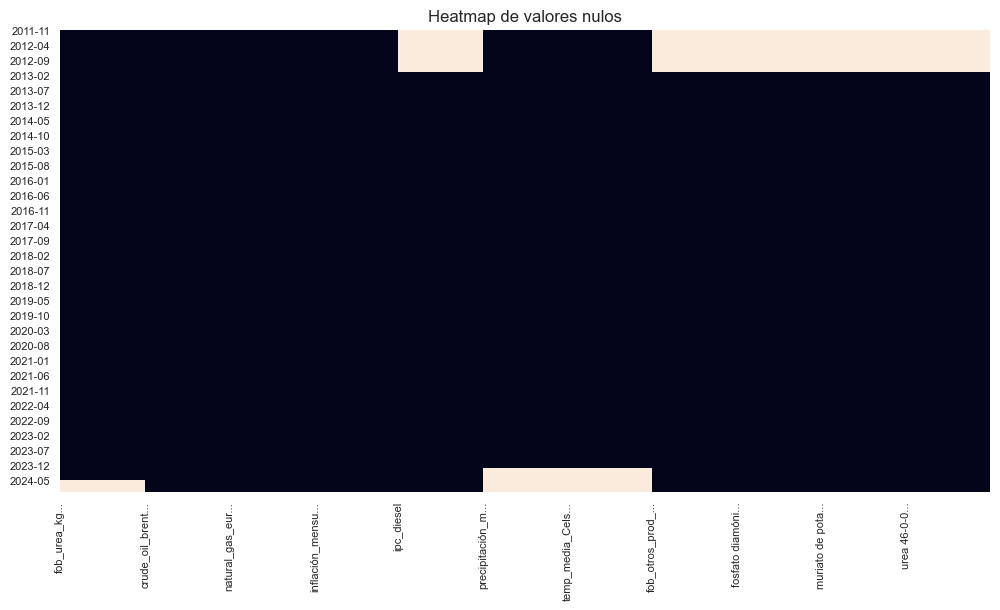

In [32]:
df_na = df.copy()

df_na.index = df_na.index.strftime('%Y-%m')

truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in df.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(df_na.isna(), cbar=False)
plt.title("Heatmap de valores nulos")
plt.xticks(ticks=range(len(df.columns)), labels=truncated_labels, size=8)
plt.yticks(size=8)
# plt.tight_layout()
plt.show()

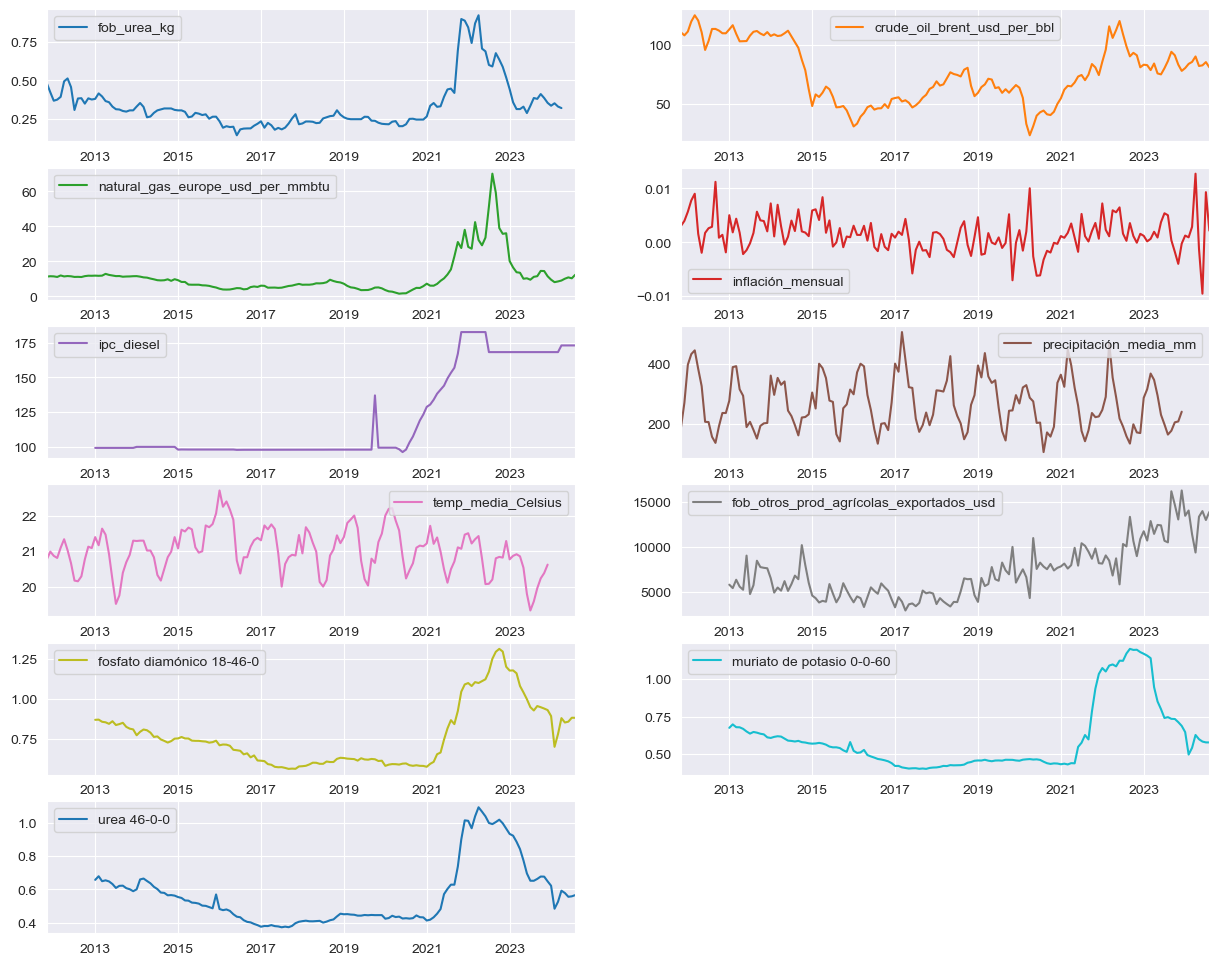

In [ ]:
num_de_filas = ((df.shape[1] + 1) // 2)

df.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

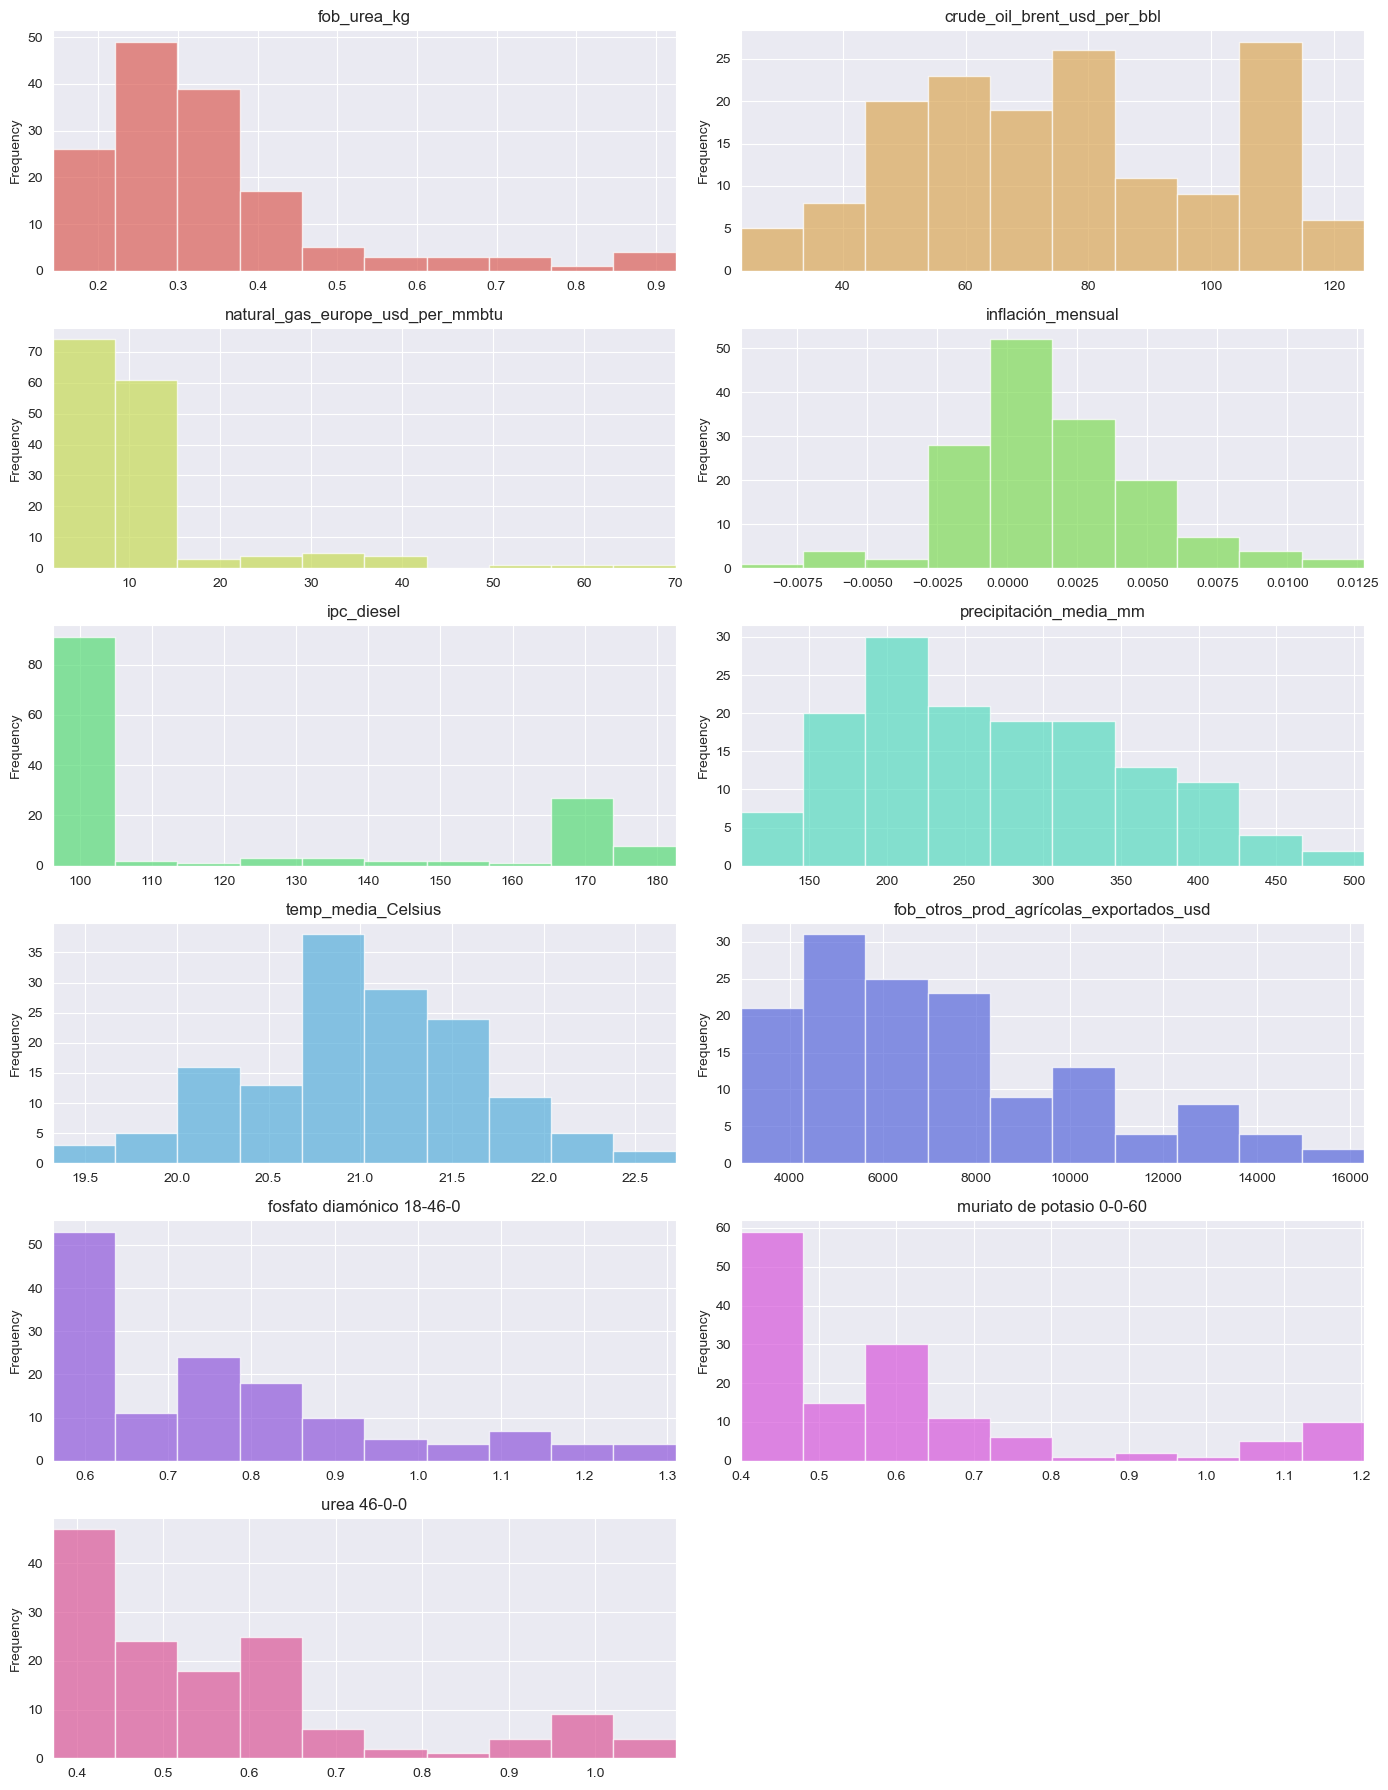

In [ ]:
plot_histograms(df, n_rows=num_de_filas, bins=10, color_palette='hls')

### Revisar homocedasticidad

In [44]:
# Recoger variables heterocedásticas en una lista:
variables_heterocedásticas = []

for col in df_na.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_na[col])
    
    # # Imprimir estadísticos:
    # print(f"{col} ->  LM Statistic: {lm_stat}, p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:
    if p_value <= 0.05:
        variables_heterocedásticas.append(col)

# Crear un DataFrame de variables heterocedásticas:
df_heterocedásticas = df_na[variables_heterocedásticas].dropna()

df_heterocedásticas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 2013-01 to 2024-04
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              136 non-null    float64
 1   crude_oil_brent_usd_per_bbl              136 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         136 non-null    float64
 3   ipc_diesel                               136 non-null    float64
 4   fob_otros_prod_agrícolas_exportados_usd  136 non-null    float64
 5   fosfato diamónico 18-46-0                136 non-null    float64
 6   muriato de potasio 0-0-60                136 non-null    float64
 7   urea 46-0-0                              136 non-null    float64
dtypes: float64(8)
memory usage: 9.6+ KB


In [45]:
df_ln_heterocedásticas = df_heterocedásticas.apply(np.log)

for col in df_ln_heterocedásticas.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_ln_heterocedásticas[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:

fob_urea_kg ->  p-value: 0.0
crude_oil_brent_usd_per_bbl ->  p-value: 0.92
natural_gas_europe_usd_per_mmbtu ->  p-value: 0.0
ipc_diesel ->  p-value: 0.0
fob_otros_prod_agrícolas_exportados_usd ->  p-value: 0.0
fosfato diamónico 18-46-0 ->  p-value: 0.581
muriato de potasio 0-0-60 ->  p-value: 0.048
urea 46-0-0 ->  p-value: 0.024


In [47]:
from scipy.stats import boxcox

df_heterocedásticas_boxcox = pd.DataFrame(index=df_heterocedásticas.index)

for col in df_heterocedásticas.columns:
    df_heterocedásticas_boxcox[col], lmbda = boxcox(df_heterocedásticas[col])

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(df_heterocedásticas_boxcox[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")

fob_urea_kg ->  p-value: 0.001
crude_oil_brent_usd_per_bbl ->  p-value: 0.542
natural_gas_europe_usd_per_mmbtu ->  p-value: 0.001
ipc_diesel ->  p-value: 0.0
fob_otros_prod_agrícolas_exportados_usd ->  p-value: 0.0
fosfato diamónico 18-46-0 ->  p-value: 0.944
muriato de potasio 0-0-60 ->  p-value: 0.396
urea 46-0-0 ->  p-value: 0.145


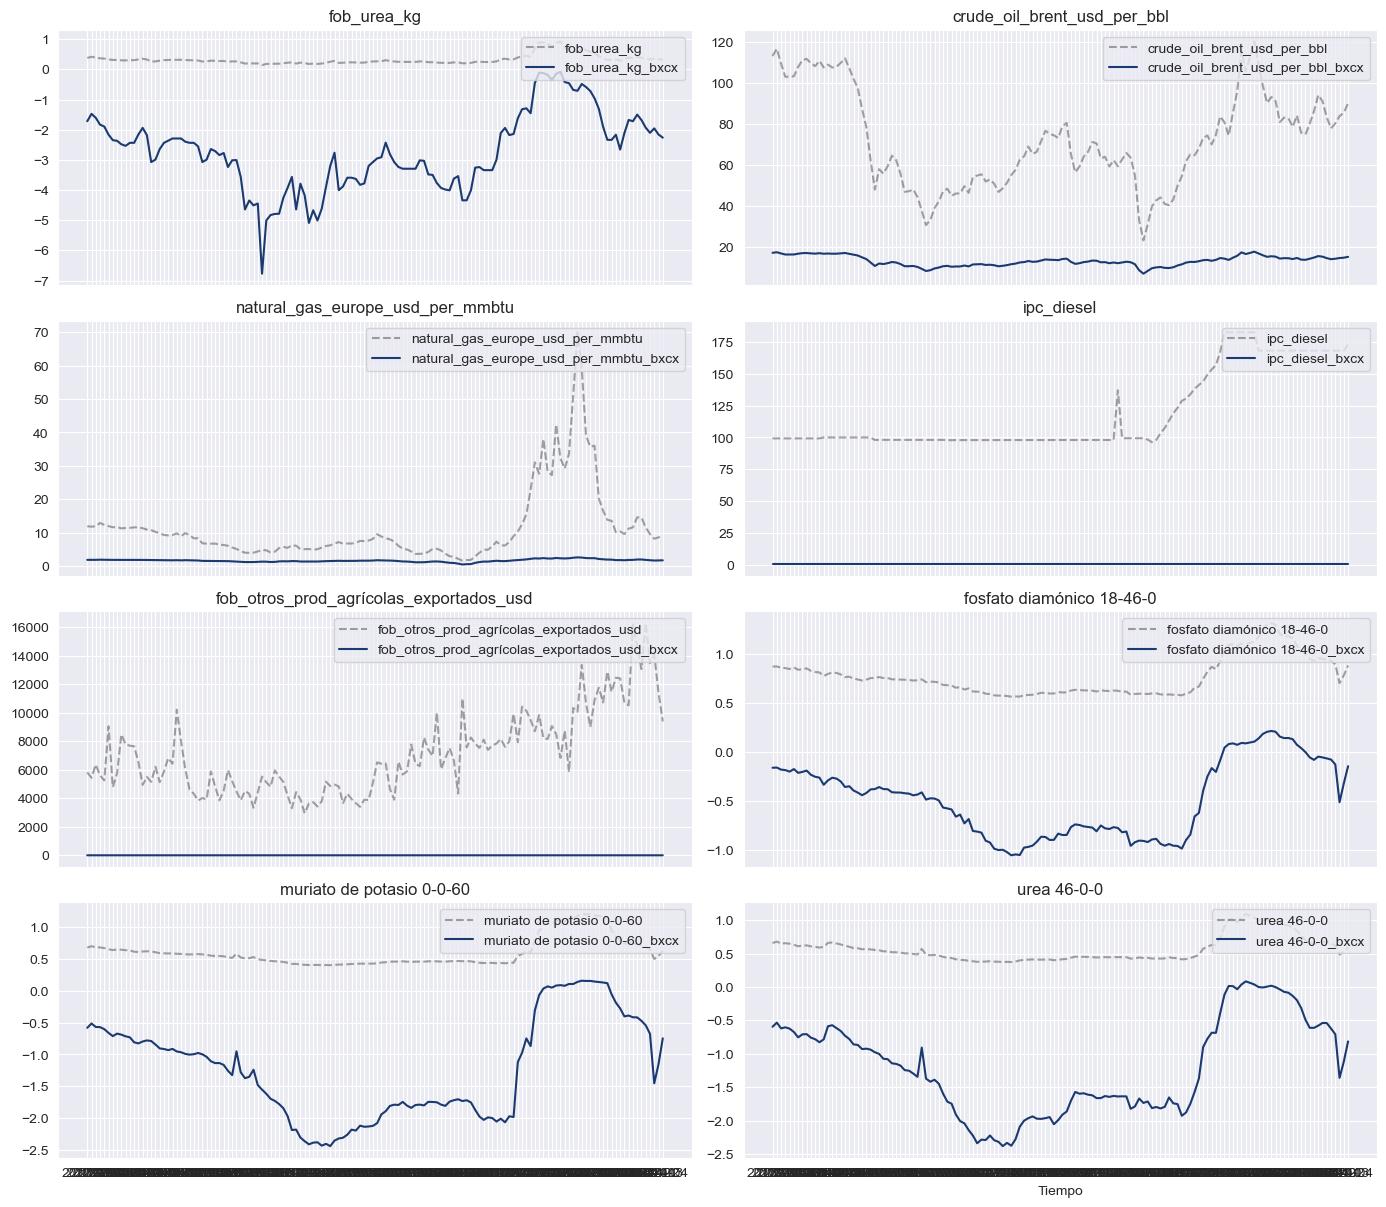

In [48]:
plot_comparison(df_heterocedásticas, df_heterocedásticas_boxcox, suffix='_bxcx')

### Diferenciación estacional

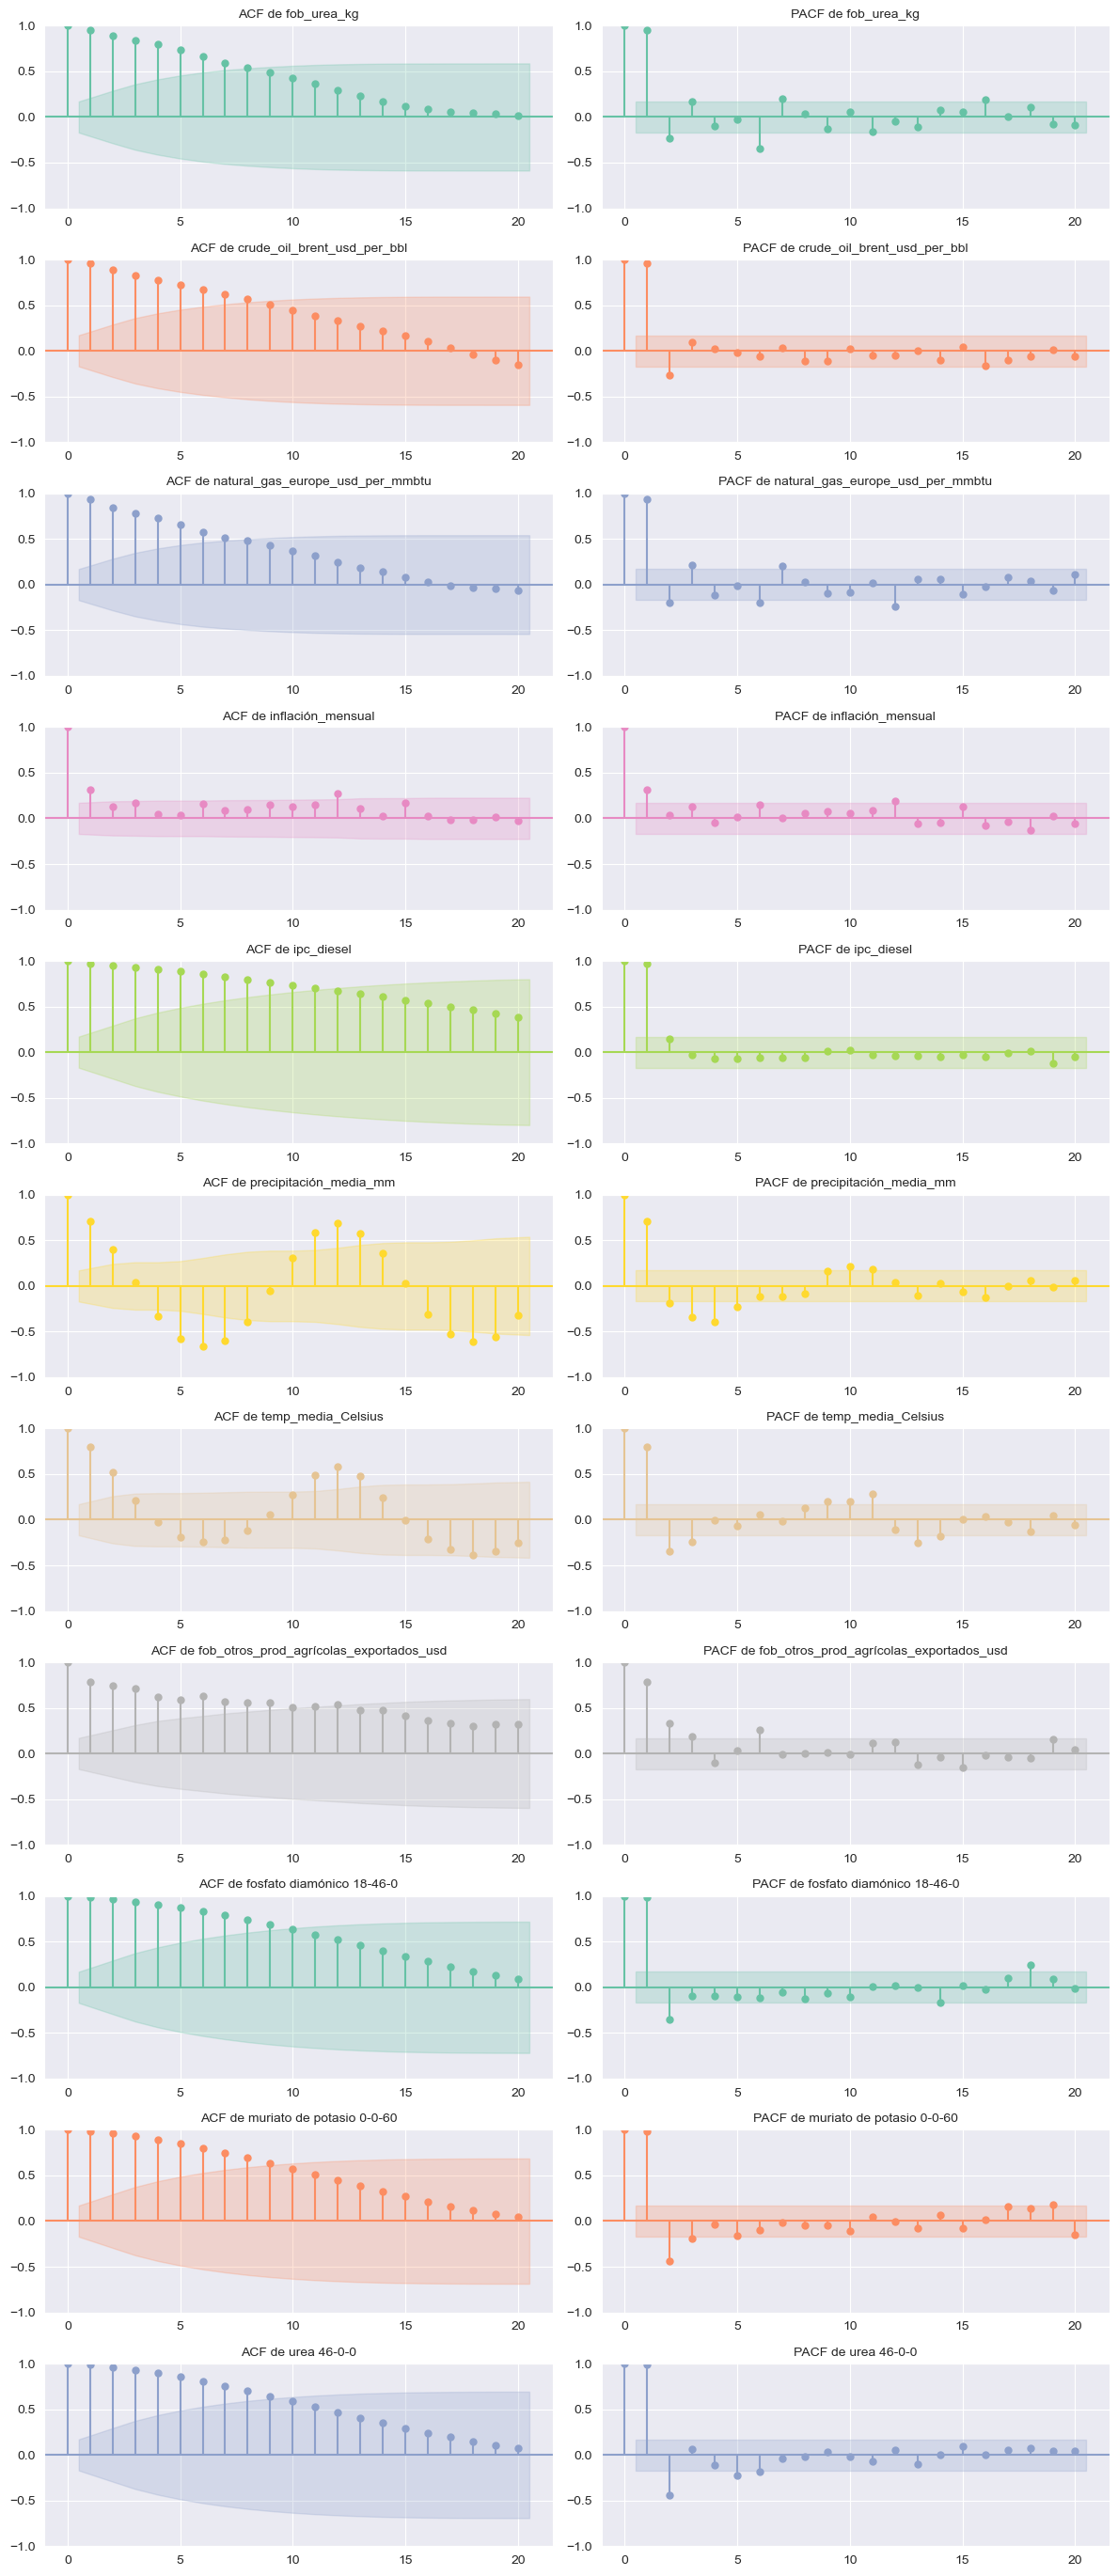

In [ ]:
plot_acf_pacf(df.dropna(), lags=20, color_palette='Set2')

In [49]:
lista_var_estacionales = ['precipitación_media_mm', 'temp_media_Celsius']

var_estacionales = df[lista_var_estacionales].dropna()

var_estacionales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146 entries, 2011-11-30 to 2023-12-31
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   precipitación_media_mm  146 non-null    float64
 1   temp_media_Celsius      146 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


In [50]:
from statsmodels.tsa.stattools import adfuller

for col in var_estacionales.columns:
# Prueba ADF con términos estacionales
    adf_result = adfuller(var_estacionales[col], regression='ct')  # 'ct' incluye tendencia y constante
    print(col, ":")
    print("-> ADF Statistic:", round(adf_result[0], 3))
    print("-> p-value:", round(adf_result[1], 3))

precipitación_media_mm :
-> ADF Statistic: -2.494
-> p-value: 0.331
temp_media_Celsius :
-> ADF Statistic: -1.702
-> p-value: 0.75


Los resultados de la prueba ADF con tendencia y constante (regression='ct') en las series de precipitación media (mm) y temperatura media (°C) muestran valores p altos (0.239 y 0.782, respectivamente), lo que indica que no se puede rechazar la hipótesis nula de raíz unitaria. Esto sugiere que ambas series son no estacionarias, incluso al ajustar una tendencia lineal. 

Por otra parte, la estacionalidad inherente en estas variables podría requerir una diferenciación estacional adicional para estabilizar la serie y eliminar patrones cíclicos, permitiendo su análisis con modelos que asumen estacionariedad.

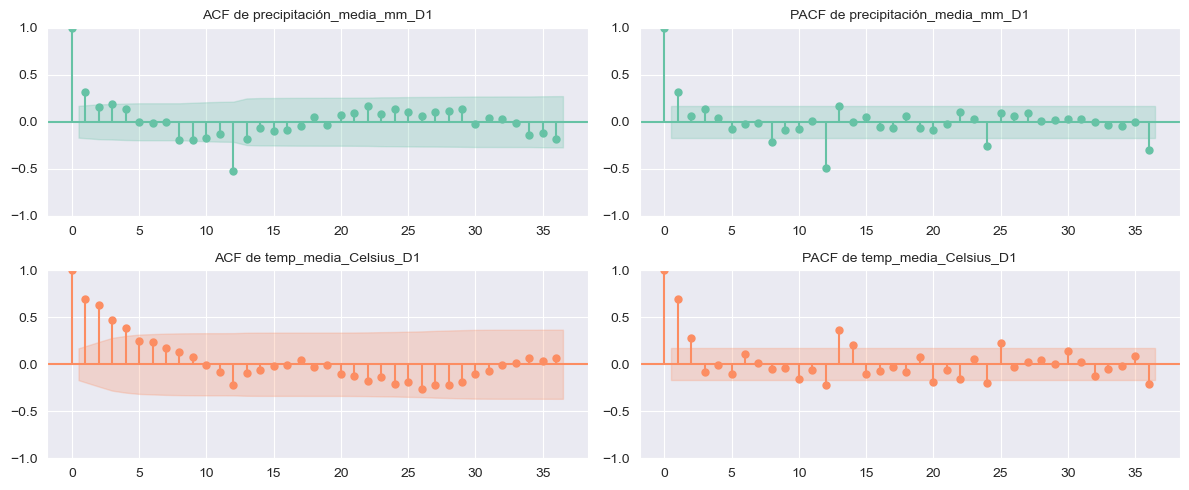

In [51]:
diff_estacional = var_estacionales.diff(12).add_suffix("_D1").dropna()

plot_acf_pacf(diff_estacional, lags=36, color_palette='Set2')

Un pico significativo en el lag estacional (12) del ACF en  es un patrón común y esperado en series originalmente estacionales y no requiere más transformaciones si la serie es estacionaria tras la diferenciación. Notamos este patrón en el ACF de `precipitación_media_mm_D1` mas no en `temp_media_Celsius_D1`.

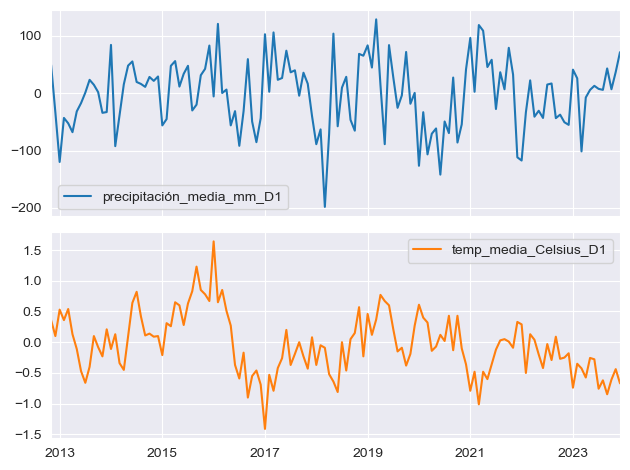

In [52]:
diff_estacional.plot(subplots=True)
plt.tight_layout()
plt.show()

En los gráficos de línea de las series con diferenciación estacional D=1 (12 períodos), notamos que la varianza de `precipitación_media_mm_D1`; no así la varianza de `temp_media_Celsius_D1`.

Estacionareidad evaluada por *Augmented Dickey-Fuller* (ADF) y *Kwiatkowski-Phillips-Schmidt-Shin* (KPSS):

In [53]:
diff_estacional = diff_estacional.dropna()

evaluar_estacionareidad_series_estacionales = evaluar_estacionareidad(diff_estacional)

evaluar_estacionareidad_series_estacionales

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,precipitación_media_mm_D1,0.000092,0.100000,True,False,Estacionario
1,temp_media_Celsius_D1,0.517717,0.077895,False,False,No claro


**Conclusión:** La diferenciación estacional `D=1` convirtió la variable `precipitación_media_mm` en estacionaria exitosamente, pero `temp_media_Celsius_D1` requiere modelado adicional.

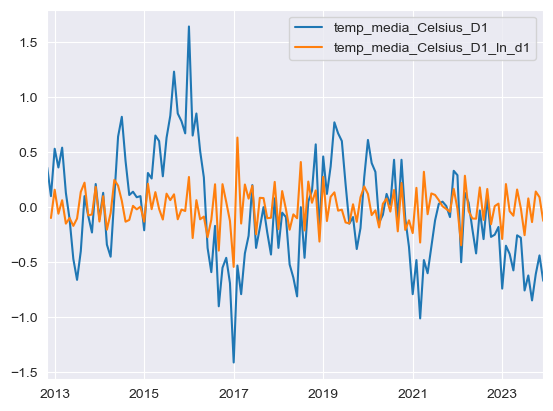

In [54]:
# Aplicar transformaciones para que 'temp_media_Celsius_D1' alcance estacionareidad:
diff_estacional['temp_media_Celsius_D1_ln_d1'] = diff_estacional['temp_media_Celsius_D1']\
    .add(-diff_estacional['temp_media_Celsius_D1'].min() + 1)\
    .apply(np.log)\
    .diff()

# Comparación visual entre 
diff_estacional['temp_media_Celsius_D1'].plot()
diff_estacional['temp_media_Celsius_D1_ln_d1'].plot()
plt.legend()
plt.show()

In [55]:
diff_estacional = diff_estacional.dropna()

evaluar_estacionareidad_series_estacionales = evaluar_estacionareidad(diff_estacional)

evaluar_estacionareidad_series_estacionales

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,precipitación_media_mm_D1,0.000076,0.100000,True,False,Estacionario
1,temp_media_Celsius_D1,0.518581,0.082785,False,False,No claro
2,temp_media_Celsius_D1_ln_d1,0.000002,0.100000,True,False,Estacionario


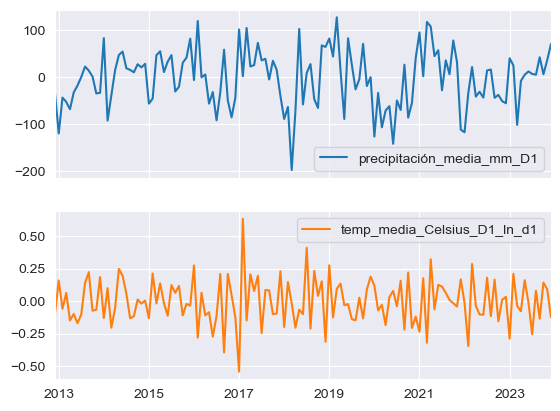

In [56]:
var_estacionales_estacionarias = diff_estacional.drop(columns=['temp_media_Celsius_D1'])

var_estacionales_estacionarias.plot(subplots=True)
plt.show()

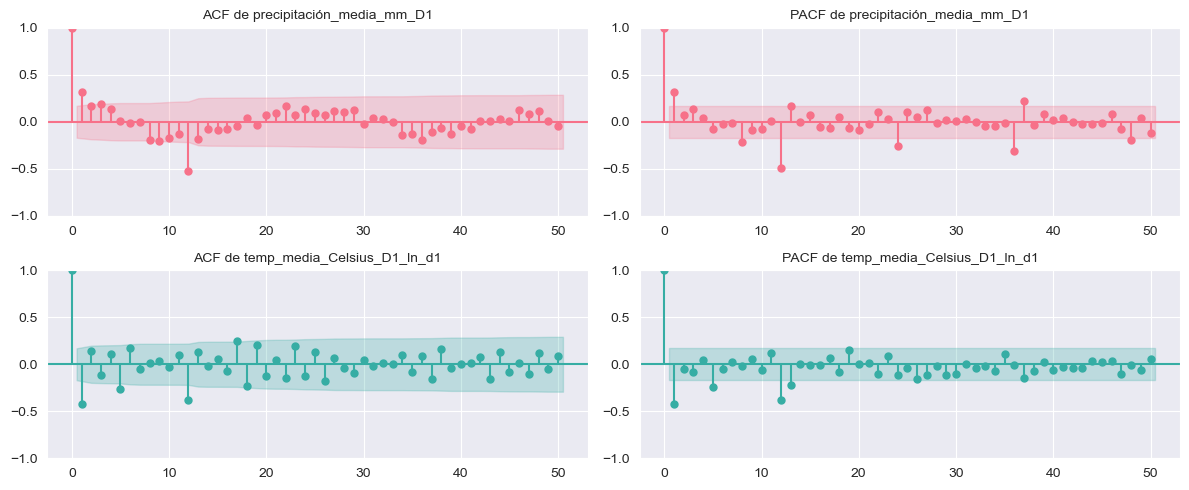

In [57]:
plot_acf_pacf(var_estacionales_estacionarias.dropna(), lags=50)

In [58]:
var_estacionales_estacionarias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2012-12-31 to 2023-12-31
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   precipitación_media_mm_D1    133 non-null    float64
 1   temp_media_Celsius_D1_ln_d1  133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


### Variables no estacionales

In [120]:
y = 'urea 46-0-0'

# Eliminar valores nulos para análisis de estacionareidad:
var_no_estacionales = df.drop(columns=lista_var_estacionales)['2012-11-30':'2024-03-31'].dropna()

var_no_estacionales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2013-01-31 to 2024-03-31
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   fob_urea_kg                              135 non-null    float64
 1   crude_oil_brent_usd_per_bbl              135 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu         135 non-null    float64
 3   inflación_mensual                        135 non-null    float64
 4   ipc_diesel                               135 non-null    float64
 5   fob_otros_prod_agrícolas_exportados_usd  135 non-null    float64
 6   fosfato diamónico 18-46-0                135 non-null    float64
 7   muriato de potasio 0-0-60                135 non-null    float64
 8   urea 46-0-0                              135 non-null    float64
dtypes: float64(9)
memory usage: 10.5 KB


In [121]:
# Extraer valores de meses para creación de índices tras diferenciación:
mes_2 = var_no_estacionales.index.min() + pd.DateOffset(months=1)
mes_2 = mes_2.strftime('%Y-%m')

mes_3 = var_no_estacionales.index.min() + pd.DateOffset(months=2)
mes_3 = mes_3.strftime('%Y-%m')

mes_4 = var_no_estacionales.index.min() + pd.DateOffset(months=3)
mes_4 = mes_4.strftime('%Y-%m')

último_mes = var_no_estacionales.index.max() + pd.DateOffset(months=1)
último_mes = último_mes.strftime('%Y-%m')

In [122]:
# Evaluar estadísticos ADF y KPSS de estacionareidad sobre datos originales:
df_test_estacionareidad = evaluar_estacionareidad(var_no_estacionales)

df_test_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg,2.193963e-01,0.023028,False,True,No estacionario
1,crude_oil_brent_usd_per_bbl,1.134769e-01,0.100000,False,False,No claro
2,natural_gas_europe_usd_per_mmbtu,2.682730e-01,0.038309,False,True,No estacionario
3,inflación_mensual,3.809845e-13,0.085182,True,False,Estacionario
4,ipc_diesel,9.595216e-01,0.010000,False,True,No estacionario
5,fob_otros_prod_agrícolas_exportados_usd,9.985632e-01,0.010000,False,True,No estacionario
6,fosfato diamónico 18-46-0,1.518363e-01,0.023557,False,True,No estacionario
7,muriato de potasio 0-0-60,3.831017e-01,0.022372,False,True,No estacionario
8,urea 46-0-0,1.463115e-01,0.026651,False,True,No estacionario


#### Diferenciación d=1:

In [123]:
q_inferior = 0
q_superior = 1

In [124]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

# Extraer nombres de variables que no son originalmente estacionarias:
variables_no_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] != 'Estacionario']['variable'].values

# Crear un df de variables no estacionarias:
df_no_estacionarias = var_no_estacionales[variables_no_estacionarias]


In [125]:

# Diferenciar para d=1 y agregar sufijo:
df_no_estacionarias_diferenciadas_d1 = df_no_estacionarias\
    .apply(np.diff, n=1)\
    .add_suffix("_d1")

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d1.index = pd.date_range(start=mes_2, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d1_tmd = df_no_estacionarias_diferenciadas_d1\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

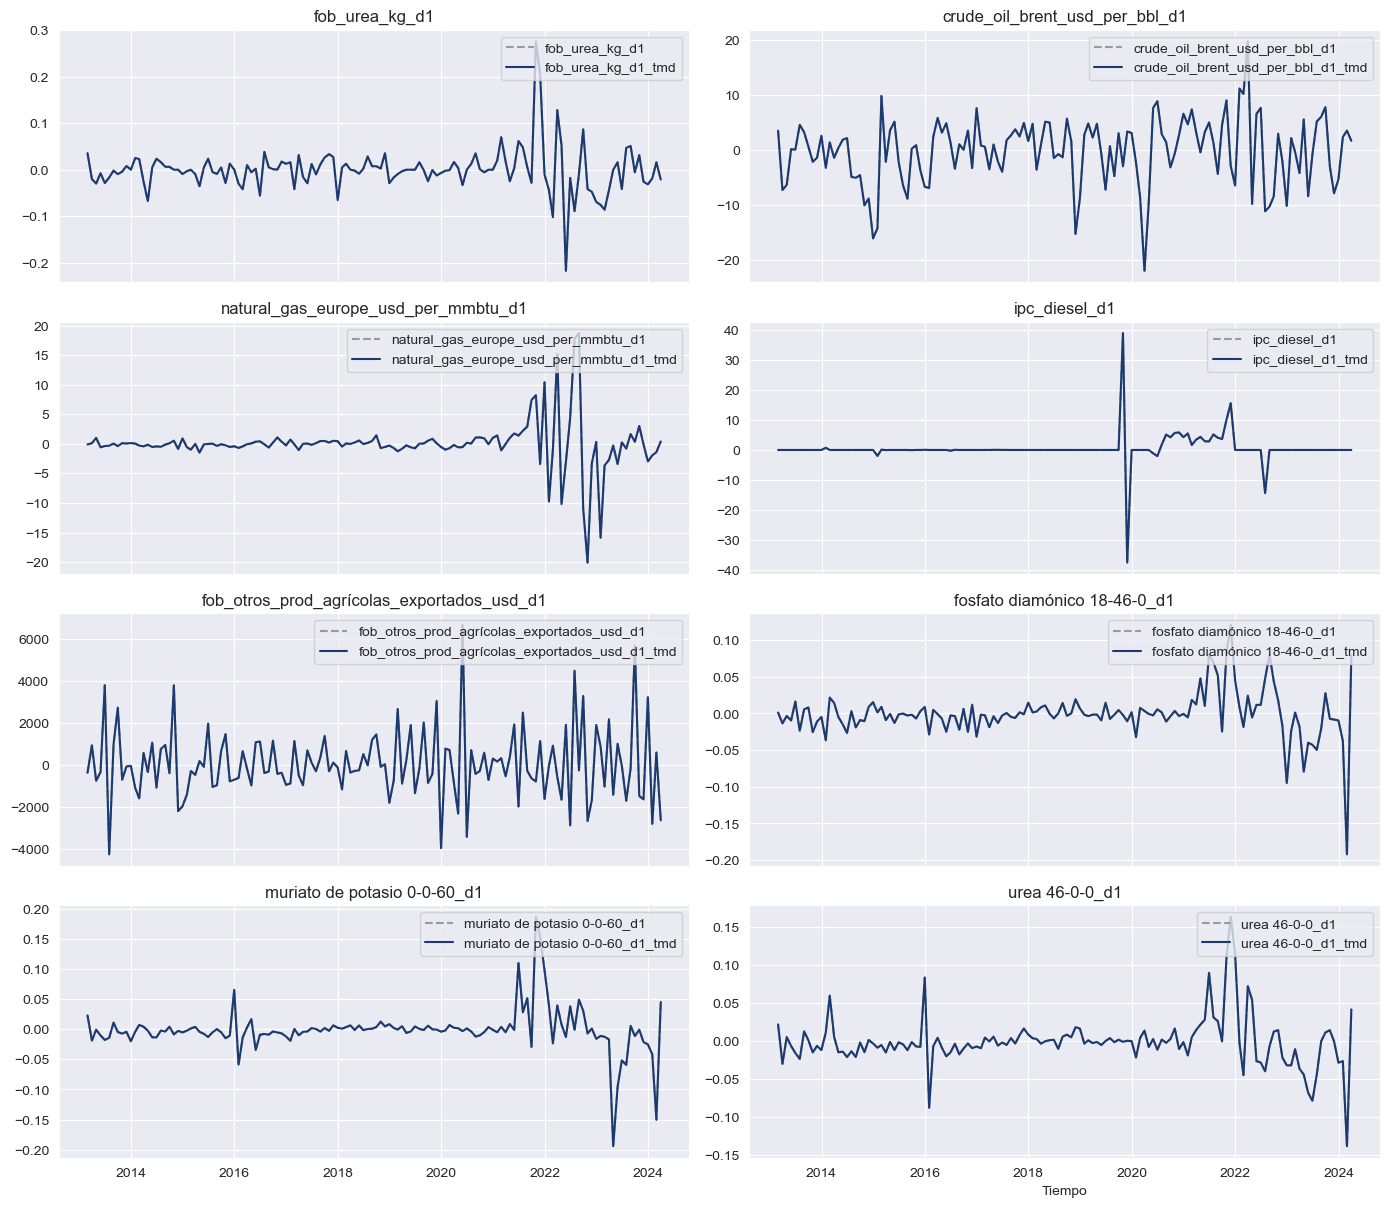

In [126]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d1, df_no_estacionarias_diferenciadas_d1_tmd, suffix='_tmd')

In [127]:
# Evaluar estadísticos ADF y KPSS de estacionareidad tras diferenciación d=1 y recorte:
df_test_estacionareidad_d1 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d1_tmd)

df_test_estacionareidad_d1

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_urea_kg_d1,5.245918e-04,0.1,True,False,Estacionario
1,crude_oil_brent_usd_per_bbl_d1,1.056183e-11,0.1,True,False,Estacionario
2,natural_gas_europe_usd_per_mmbtu_d1,1.061201e-05,0.1,True,False,Estacionario
3,ipc_diesel_d1,3.394431e-28,0.1,True,False,Estacionario
4,fob_otros_prod_agrícolas_exportados_usd_d1,7.542547e-02,0.1,False,False,No claro
5,fosfato diamónico 18-46-0_d1,1.819057e-13,0.1,True,False,Estacionario
6,muriato de potasio 0-0-60_d1,1.998132e-05,0.1,True,False,Estacionario
7,urea 46-0-0_d1,5.160035e-02,0.1,False,False,No claro


In [128]:
# Extraer nombres de variables que no son estacionarias después de d=1 pero antes del recorte:
variables_no_estacionarias_tras_d1 = df_test_estacionareidad_d1[df_test_estacionareidad_d1['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d1_tmd = df_no_estacionarias_diferenciadas_d1_tmd\
    .drop(columns=variables_no_estacionarias_tras_d1)\
    # .add_suffix('_tmd')

df_variables_estacionarias_d1_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2013-02-28 to 2024-03-31
Freq: ME
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   fob_urea_kg_d1                       134 non-null    float64
 1   crude_oil_brent_usd_per_bbl_d1       134 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu_d1  134 non-null    float64
 3   ipc_diesel_d1                        134 non-null    float64
 4   fosfato diamónico 18-46-0_d1         134 non-null    float64
 5   muriato de potasio 0-0-60_d1         134 non-null    float64
dtypes: float64(6)
memory usage: 7.3 KB


#### Diferenciación d=2:

In [129]:
# Crear un df de variables no estacionarias tras d=1 pero antes del recorte de extremos:
df_no_estacionarias_d1 = df_no_estacionarias_diferenciadas_d1[variables_no_estacionarias_tras_d1]

# Segunda diferenciación de variables no estacionarias tras d=1:
df_no_estacionarias_diferenciadas_d2 = df_no_estacionarias_d1.apply(np.diff, n=1)

# Cambiar el nombre de columnas para identificar 'd=2':
df_no_estacionarias_diferenciadas_d2.columns = [col.replace("_d1", "_d2") for col in df_no_estacionarias_diferenciadas_d2.columns]

# Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
df_no_estacionarias_diferenciadas_d2.index = pd.date_range(start=mes_3, end=último_mes, freq='ME')

# Recortar valores extremos bajo criterio de cuantiles:
df_no_estacionarias_diferenciadas_d2_tmd = df_no_estacionarias_diferenciadas_d2\
    .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))

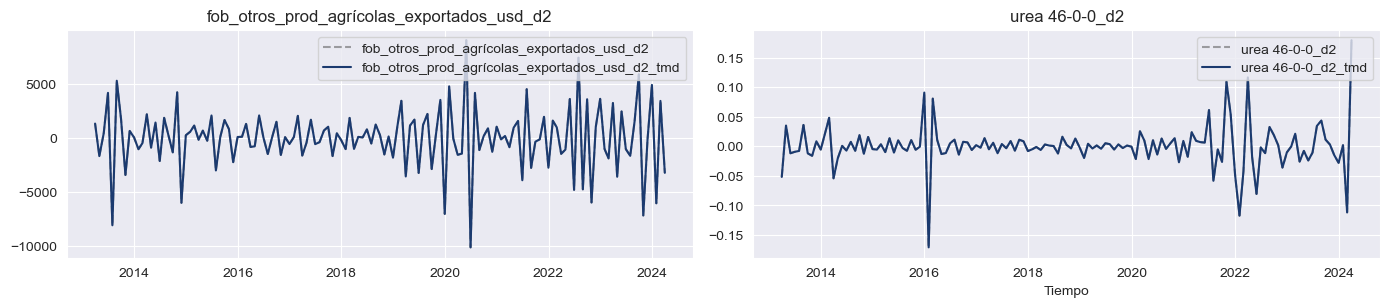

In [130]:
# Visualizar diferencias en datos tras recortes de valores extremos:
plot_comparison(df_no_estacionarias_diferenciadas_d2, df_no_estacionarias_diferenciadas_d2_tmd, suffix='_tmd')

In [131]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
df_test_estacionareidad_d2 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d2_tmd)

df_test_estacionareidad_d2

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,fob_otros_prod_agrícolas_exportados_usd_d2,6.844011e-14,0.1,True,False,Estacionario
1,urea 46-0-0_d2,1.378120e-18,0.1,True,False,Estacionario


In [132]:
# Extraer nombres de variables que no son estacionarias después de d=2 pero antes del recorte:
variables_no_estacionarias_tras_d2 = df_test_estacionareidad_d2[df_test_estacionareidad_d2['estado_estacionario'] != 'Estacionario']['variable'].values

# Obtener un DataFrame que solo contiene las variables estacionarias tras d=1 y eliminación de atípicos: 
df_variables_estacionarias_d2_tmd = df_no_estacionarias_diferenciadas_d2_tmd\
    .drop(columns=variables_no_estacionarias_tras_d2)\
    # .add_suffix('_tmd')

df_variables_estacionarias_d2_tmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2013-03-31 to 2024-03-31
Freq: ME
Data columns (total 2 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   fob_otros_prod_agrícolas_exportados_usd_d2  133 non-null    float64
 1   urea 46-0-0_d2                              133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


#### Diferenciación d=3:

In [133]:
# # Crear un df de variables no estacionarias tras d=2 pero antes del recorte de extremos:
# df_no_estacionarias_d2 = df_no_estacionarias_diferenciadas_d2[variables_no_estacionarias_tras_d2]

# # Tercera diferenciación de variables no estacionarias tras d=2:
# df_no_estacionarias_diferenciadas_d3 = df_no_estacionarias_d2.apply(np.diff, n=1)

# # Cambiar el nombre de columnas para identificar 'd=3':
# df_no_estacionarias_diferenciadas_d3.columns = [col.replace("_d2", "_d3") for col in df_no_estacionarias_diferenciadas_d3.columns]

# # Establecer índice, tomando en cuenta que la diferenciación elimina la primera fila:
# df_no_estacionarias_diferenciadas_d3.index = pd.date_range(start=mes_4, end=último_mes, freq='ME')

# # Recortar valores extremos bajo criterio de cuantiles:
# df_no_estacionarias_diferenciadas_d3_tmd = df_no_estacionarias_diferenciadas_d3\
#     .apply(lambda x: x.clip(lower=x.quantile(q_inferior), upper=x.quantile(q_superior)))


In [134]:
# # Visualizar diferencias en datos tras recortes de valores extremos:
# plot_comparison(df_no_estacionarias_diferenciadas_d3, df_no_estacionarias_diferenciadas_d3_tmd, suffix='_tmd')

In [135]:
# # Evaluar estadísticos ADF y KPSS de estacionareidad:
# df_test_estacionareidad_d3 = evaluar_estacionareidad(df_no_estacionarias_diferenciadas_d3_tmd)

# df_test_estacionareidad_d3

In [136]:
# # Extraer nombres de variables que no son estacionarias después de d=3 pero antes del recorte:
# variables_no_estacionarias_tras_d3 = df_test_estacionareidad_d3[df_test_estacionareidad_d3['estado_estacionario'] != 'Estacionario']['variable'].values

# # Obtener un DataFrame que solo contiene las variables estacionarias tras d=3 y eliminación de atípicos: 
# df_variables_estacionarias_d3_tmd = df_no_estacionarias_diferenciadas_d3_tmd\
#     .drop(columns=variables_no_estacionarias_tras_d3)\
#     .add_suffix('_tmd')

# df_variables_estacionarias_d3_tmd.info()

### Cohesión de variables estacionarias y con valores extremos recortados:

In [142]:
# Extraer las variables originalmente estacionarias:
variables_originalmente_estacionarias = df_test_estacionareidad[df_test_estacionareidad['estado_estacionario'] == 'Estacionario']['variable'].values

df_originalmente_estacionarias = var_no_estacionales[variables_originalmente_estacionarias]

df_estacionarios = pd.concat(
    [df_originalmente_estacionarias, var_estacionales_estacionarias, df_variables_estacionarias_d1_tmd, df_variables_estacionarias_d2_tmd], # df_variables_estacionarias_d3_tmd], 
    axis=1, 
    join='outer'
    )\
        .fillna(df_estacionarios.median())\
        ['2013':'2023']

df_estacionarios.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Freq: ME
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   inflación_mensual                           132 non-null    float64
 1   precipitación_media_mm_D1                   132 non-null    float64
 2   temp_media_Celsius_D1_ln_d1                 132 non-null    float64
 3   fob_urea_kg_d1                              132 non-null    float64
 4   crude_oil_brent_usd_per_bbl_d1              132 non-null    float64
 5   natural_gas_europe_usd_per_mmbtu_d1         132 non-null    float64
 6   ipc_diesel_d1                               132 non-null    float64
 7   fosfato diamónico 18-46-0_d1                132 non-null    float64
 8   muriato de potasio 0-0-60_d1                132 non-null    float64
 9   fob_otros_prod_agrícolas_exportados_usd_d2  132 non-null   

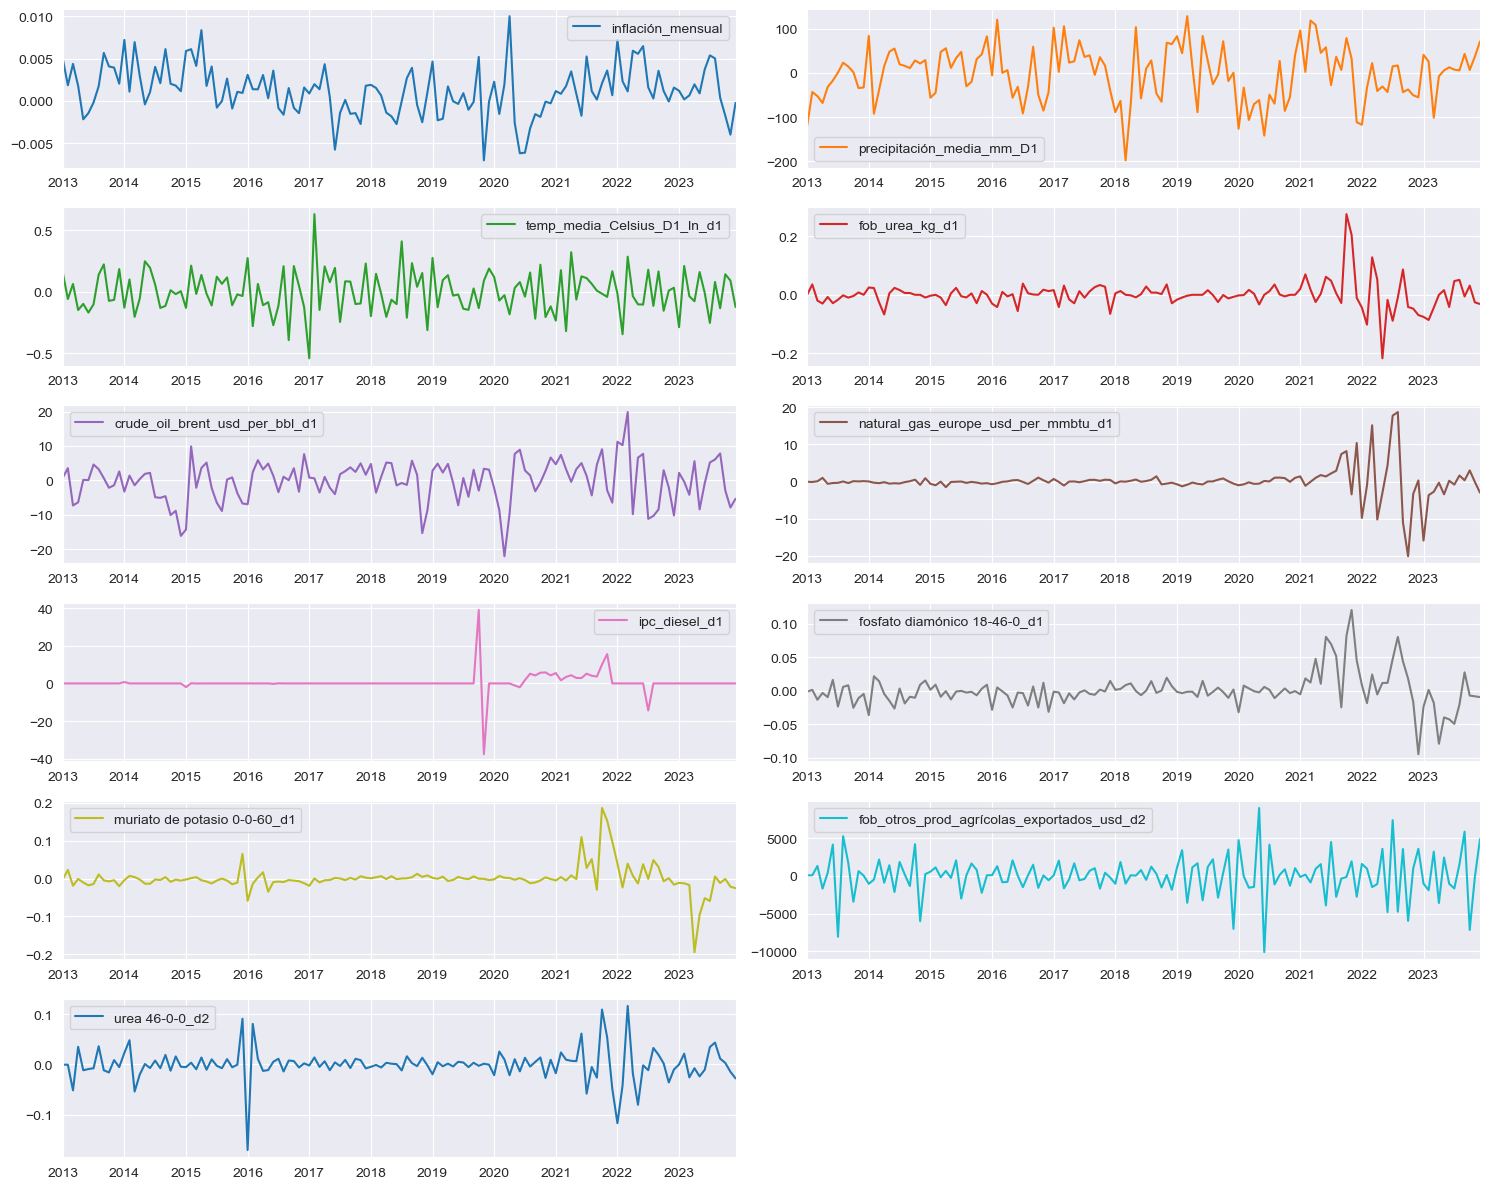

In [143]:
num_de_filas = ((df_estacionarios.shape[1] + 1) // 2)

df_estacionarios.plot(
    subplots=True,
    layout=(num_de_filas, 2),
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )

plt.tight_layout()
plt.show()

In [144]:
# df_estacionarios.to_csv('data/df_estacionarios.csv')

In [145]:
# Evaluar estadísticos ADF y KPSS de estacionareidad:
verificar_estacionareidad = evaluar_estacionareidad(df_estacionarios)

verificar_estacionareidad

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
1,precipitación_media_mm_D1,1.389231e-04,0.100000,True,False,Estacionario
2,temp_media_Celsius_D1_ln_d1,1.921345e-06,0.100000,True,False,Estacionario
3,fob_urea_kg_d1,5.776155e-04,0.100000,True,False,Estacionario
4,crude_oil_brent_usd_per_bbl_d1,2.694252e-13,0.100000,True,False,Estacionario
5,natural_gas_europe_usd_per_mmbtu_d1,1.324380e-05,0.100000,True,False,Estacionario
6,ipc_diesel_d1,4.765658e-28,0.100000,True,False,Estacionario
7,fosfato diamónico 18-46-0_d1,1.234462e-02,0.100000,True,False,Estacionario
8,muriato de potasio 0-0-60_d1,3.517005e-05,0.100000,True,False,Estacionario
9,fob_otros_prod_agrícolas_exportados_usd_d2,2.060922e-14,0.100000,True,False,Estacionario


In [155]:
# Extraer variables predictoras:
X = df_estacionarios.drop(columns=['fosfato diamónico 18-46-0_d1', 'muriato de potasio 0-0-60_d1', 'urea 46-0-0_d2'])

# Extraer variable objetivo:
target_var = 'urea 46-0-0_d2'

y = df_estacionarios[target_var]

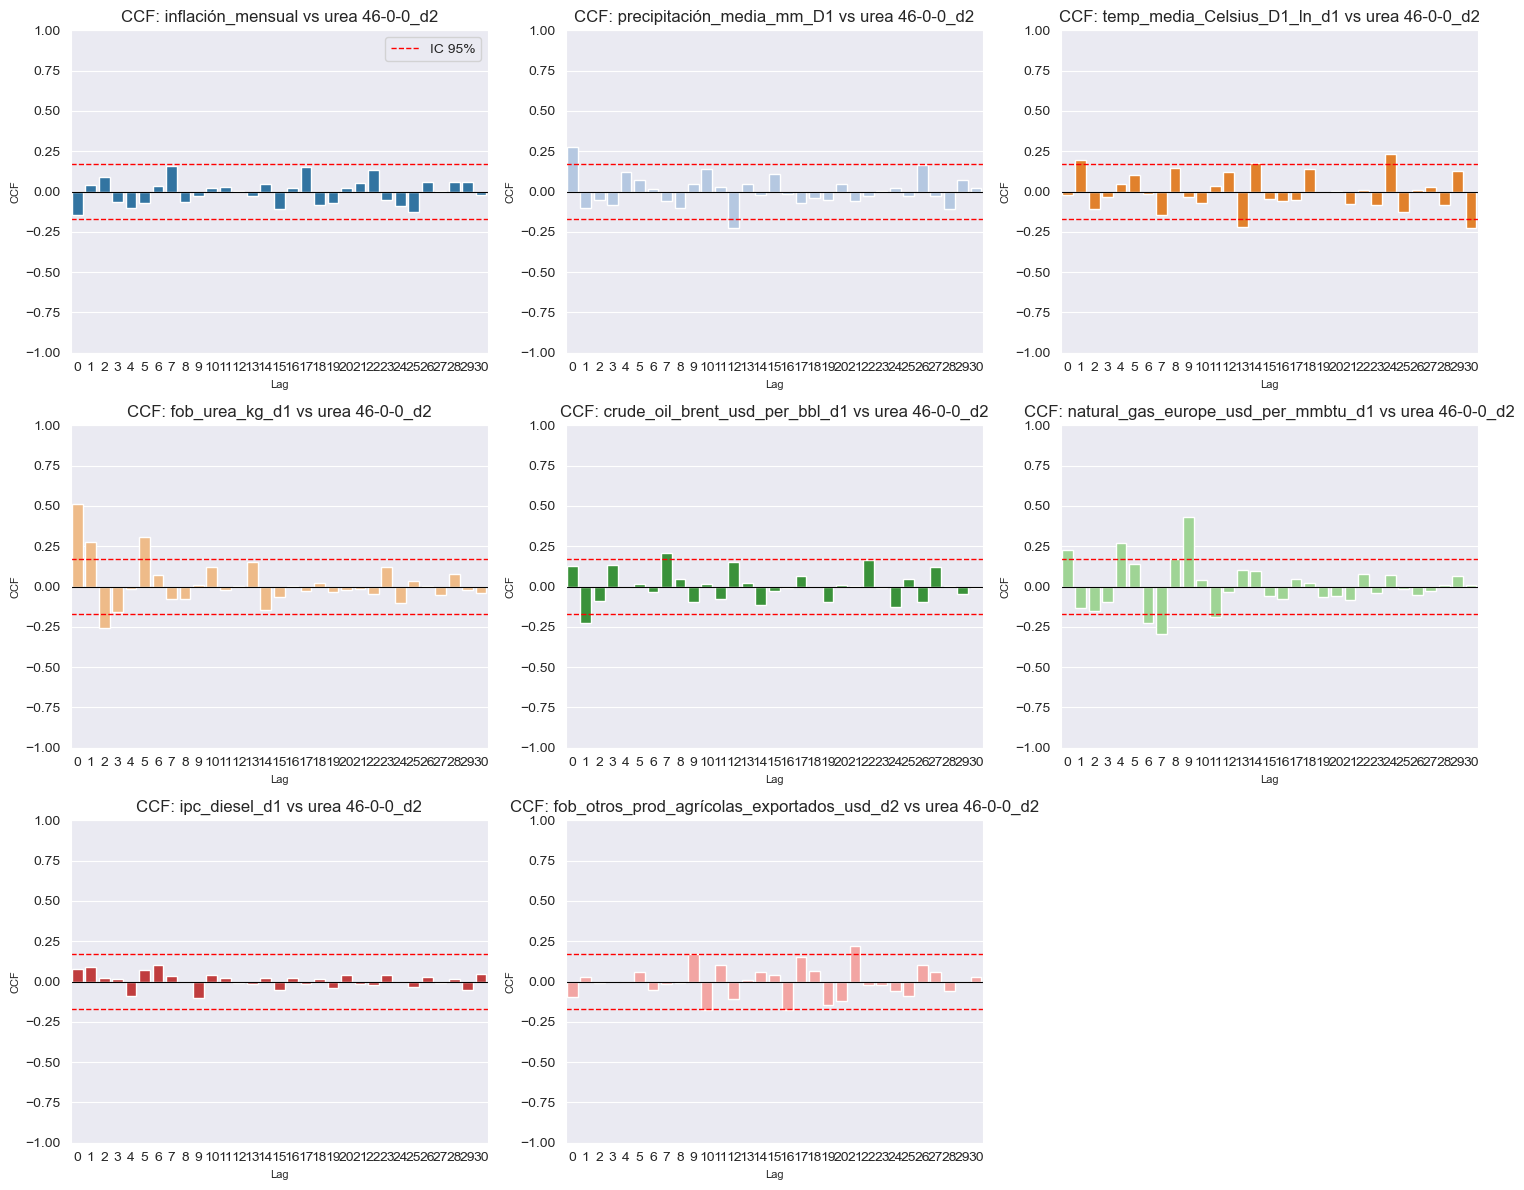

In [156]:
plot_ccf_subplots(df_estacionarios, X.columns.tolist(), target_var, max_lag=30, palette_name="tab20")

In [157]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crear un DataFrame para almacenar los VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
6,ipc_diesel_d1,1.186206
3,fob_urea_kg_d1,1.138437
0,inflación_mensual,1.096301
5,natural_gas_europe_usd_per_mmbtu_d1,1.058873
2,temp_media_Celsius_D1_ln_d1,1.057095
1,precipitación_media_mm_D1,1.053679
7,fob_otros_prod_agrícolas_exportados_usd_d2,1.027166
4,crude_oil_brent_usd_per_bbl_d1,1.010166


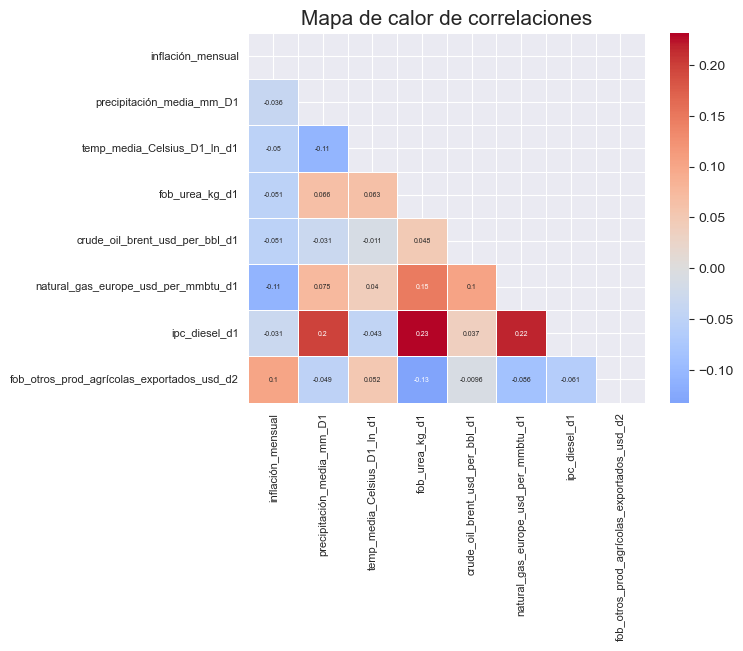

In [158]:
# Graficar mapa de calor de correlaciones no lineales:
corr = X.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [159]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Agrega una constante para el intercepto
modelo_robusto = sm.OLS(y, X).fit(cov_type='HC0')  # Modelo robusto a heterocedasticidad
print(modelo_robusto.summary())

                            OLS Regression Results                            
Dep. Variable:         urea 46-0-0_d2   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     12.19
Date:               vi., 15 nov. 2024   Prob (F-statistic):           1.00e-12
Time:                        15:38:02   Log-Likelihood:                 295.81
No. Observations:                 132   AIC:                            -573.6
Df Residuals:                     123   BIC:                            -547.7
Df Model:                           8                                         
Covariance Type:                  HC0                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------